In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from mne.decoding import ReceptiveField
import pickle
import numpy as np
import  modin.pandas as pd
import os
from tqdm import tqdm
from NRC import NRC,recordModule
from matplotlib.pyplot import MultipleLocator
from matplotlib.gridspec import GridSpec
from utils import returnSpec
from distributed import Client
client = Client()

## 数据导入
可以选择导入 *exp* 文件夹中的‘EEG’，’TRF‘，或者’stimulus'文件。文件都是按照pickle格式存储。因为将所有的数据都汇总到一起，所以数据的读写时间会比较长。

# TRF analysis

In [2]:
TRFs = []
add = 'results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    f = pd.read_csv(subFolder+os.sep+'TRF.csv')
    TRFs.append(f)

TRFs = pd.concat(TRFs, ignore_index=True)
TRFs.head()


,Unnamed: 0.1,channel,lags,trf,condition,feauture,subject,type,tag,Unnamed: 0
0,0,PZ,-0.2,-0.501656,1,0,shinanlin,shuffled,wn,NaN
1,1,PO5,-0.2,-0.006129,1,0,shinanlin,shuffled,wn,NaN
2,2,POZ,-0.2,-0.941055,1,0,shinanlin,shuffled,wn,NaN
3,3,PO4,-0.2,-0.512750,1,0,shinanlin,shuffled,wn,NaN
4,4,PO3,-0.2,-0.458779,1,0,shinanlin,shuffled,wn,NaN


TRF的frame中
1. channel 代表通道标签
2. lags代表延迟的时间轴
3. trf代表TRF的幅度
4. condition是trigger标记，1-20是whitenoise;20-40是m-seq；40-60是ssvep
5. type代表TRF有没有被正则化：whitened代表正则化，unwhitened是纯互相关
6. tag是刺激类型：白噪声，ssvep和mseq

In [6]:
ave = TRFs[['trf', 'lags', 'tag', 'type', 'subject']].groupby(
    by=['tag', 'lags', 'type', 'subject'], as_index=False).mean()
ave = ave[ave.subject=='shinanlin']
ave.head()

,tag,lags,type,subject,trf
1,wn,-0.200000,locked,shinanlin,-0.008603
3,wn,-0.200000,shuffled,shinanlin,0.000595
5,wn,-0.195833,locked,shinanlin,0.001810
7,wn,-0.195833,shuffled,shinanlin,0.007432
9,wn,-0.191667,locked,shinanlin,0.021156


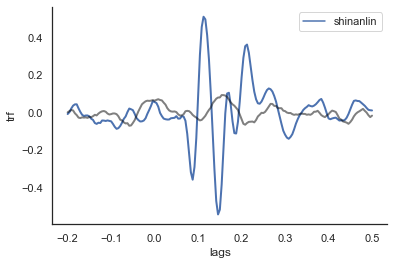

In [7]:
f,ax = plt.subplots()
sns.set_theme(style='white')
sns.lineplot(data=ave[ave.type=='locked'], x='lags', y='trf', hue='subject',style='subject',linewidth=2)
sns.lineplot(data=ave[ave.type=='shuffled'], x='lags', y='trf',linewidth=2,color='black',alpha=0.5)
sns.despine()

# plt.savefig('./images/TRF.png' ,dpi=300)

# EEG analysis

### EEGs

In [6]:
EEGs = []
add = 'results/offline'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub 
    f = pd.read_csv(subFolder+os.sep+'EEG.csv')
    EEGs.append(f)

EEGs = pd.concat(EEGs,ignore_index=True)
EEGs.head()

,Unnamed: 0,channel,time,EEG,condition,remark,tag,subject,Unnamed: 0.2,Unnamed: 0.1
0,0,PZ,0.0,0.019831,40,real,wn,huangchangxing,NaN,NaN
1,1,PO5,0.0,0.025361,40,real,wn,huangchangxing,NaN,NaN
2,2,POZ,0.0,0.015545,40,real,wn,huangchangxing,NaN,NaN
3,3,PO4,0.0,0.015735,40,real,wn,huangchangxing,NaN,NaN
4,4,PO6,0.0,0.021727,40,real,wn,huangchangxing,NaN,NaN


In [7]:
evoked = EEGs.groupby(by=['time', 'condition','subject'],as_index=False).mean()
evoked.head()

,time,condition,subject,Unnamed: 0,EEG,Unnamed: 0.2,Unnamed: 0.1
0,0.0,1,huangchangxing,232323.5,0.017927,NaN,NaN
1,0.0,1,miaoyining,205443.5,-0.005988,NaN,435843.500000
2,0.0,1,shinanlin,199923.0,-0.003010,660556.391304,430195.266667
3,0.0,2,huangchangxing,207363.5,0.018334,NaN,NaN
4,0.0,2,miaoyining,261123.5,-0.005989,NaN,491523.500000


<AxesSubplot:xlabel='time', ylabel='EEG'>

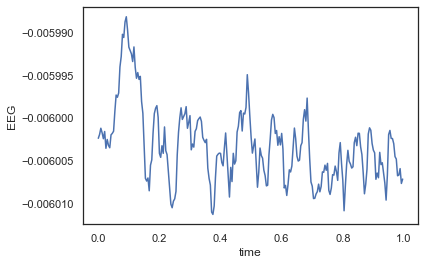

In [15]:
sns.lineplot(data=evoked[evoked.subject=='miaoyining'][(evoked.condition==10)],x='time',y='EEG')

# performance

In [2]:
scores = []
add = 'results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub 
    f = pd.read_csv(subFolder+os.sep+'classification.csv')
    scores.append(f)

scores = pd.concat(scores,ignore_index=True).drop_duplicates()
scores.head()


,Unnamed: 0,score,winLEN,tag,cv,seed,subject
0,0,0.800,0.3,wn,0,0.0,shinanlin
1,1,0.950,0.3,wn,1,0.0,shinanlin
2,2,0.925,0.3,wn,2,0.0,shinanlin
3,3,0.950,0.3,wn,3,0.0,shinanlin
4,4,0.900,0.3,wn,4,0.0,shinanlin


In [4]:
aveScore = scores.groupby(['seed','subject'],as_index=False).mean()
aveScore = aveScore.sort_values(by='score',ascending=False)
aveScore

,seed,subject,Unnamed: 0,score,winLEN,cv
472,236.0,miaoyining,1418.5,1.000000,0.3,2.5
1144,572.0,miaoyining,3434.5,0.995833,0.3,2.5
510,255.0,miaoyining,1532.5,0.995833,0.3,2.5
424,212.0,miaoyining,1274.5,0.995833,0.3,2.5
1528,764.0,miaoyining,4586.5,0.995833,0.3,2.5
...,...,...,...,...,...,...
1211,605.0,shinanlin,3632.5,0.812500,0.3,2.5
1629,814.0,shinanlin,4886.5,0.808333,0.3,2.5
1655,827.0,shinanlin,4964.5,0.808333,0.3,2.5
1913,956.0,shinanlin,5738.5,0.800000,0.3,2.5


<AxesSubplot:xlabel='seed', ylabel='score'>

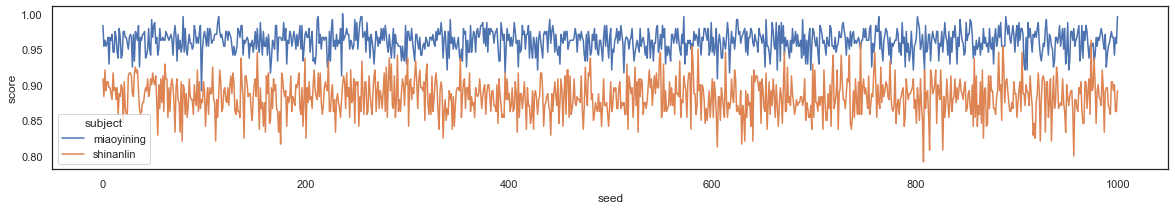

In [16]:
f,axs = plt.subplots(1,1,figsize=(20,3))
sns.set_theme(style='white')
sns.lineplot(data=aveScore,x='seed',y='score',hue='subject')

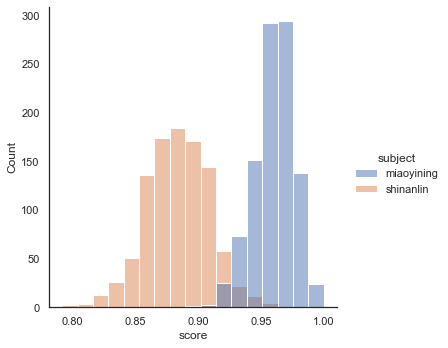

In [14]:
sns.set_theme(style='white')
sns.displot(data=aveScore,x='score',hue='subject',)

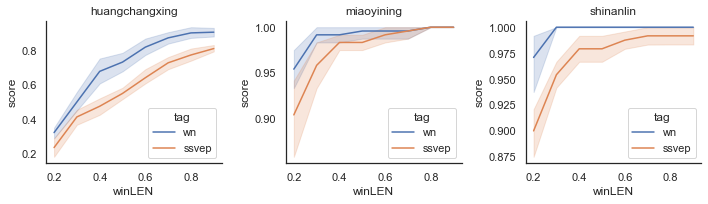

In [28]:
f,axs = plt.subplots(1,3,figsize=(10,3))
sns.set_theme(style='white')
for ax,sub in zip(axs,scores.subject.unique()):
    sns.lineplot(data=scores[scores.subject==sub],x='winLEN',y='score',hue='tag',ax=ax)
    ax.set_title('%s'%sub)
    sns.despine()
plt.tight_layout()
plt.savefig('./images/wn.png',format='png',dpi=300)